In [45]:
from neo4j import GraphDatabase


# Configure Neo4j connection settings
neo4j_url = "bolt://localhost:7691"
neo4j_user = "neo4j"
neo4j_password = "Quant8314"

# Create a Neo4j driver
driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password),database="test")

In [46]:
from graphdatascience import GraphDataScience

gds = GraphDataScience("neo4j://localhost:7691",auth=("neo4j","Quant8314"),database="test")

print(f"GDS Versoin: {gds.version()}")

GDS Versoin: 2.3.3


In [67]:
gds.run_cypher("MATCH (n) DETACH DELETE n;")
gds.run_cypher("create constraint datasource_unique if not exists for (n:Datasource) require n.name is unique;")
gds.run_cypher("create constraint table_unique if not exists for (n:Table) require n.name is unique;")
gds.run_cypher("create constraint owner_unique if not exists for (n:Owner) require n.name is unique;")
gds.run_cypher("create constraint role_unique if not exists for (n:Role) require n.name is unique;")

""


In [68]:
gds.run_cypher(
"""
merge (d1:Datasource {name:'BookShop Transactional'})
merge (d2:Datasource {name:'KDS Clickstream'})
merge (d3:Datasource {name:'User Transactions'})
merge (d4:Datasource {name:'Insurance Policies'})
merge (t1:Table:Dataset {name:'dim_countries'})
merge (t2:Table:Dataset {name:'customer_tier_sbx'})
merge (t3:KafkaTopic:Dataset {name:'kds_clickstream',namespace:'Messaging'})
merge (t4:KafkaTopic:Dataset {name:'user_transactions_west',namespace:'Messaging'})
merge (t5:Table:Dataset {name:'t_contract_master'})
merge (t6:Table:Dataset {name:'DM_Policy_Agent_Risk_Detail'})
merge (o1:Owner {name:'Data Engineer'})
merge (o2:Owner {name:'Data Product'})
merge (o3:Owner {name:'Data Science Engineer'})
merge (o4:Owner {name:'Data Platform Engineer'})
merge (o5:Owner {name:'Life Insurance'})
merge (u1:User {name:'Maruthi Skybey'})
merge (u2:User {name:'Lokanathan Skybey'})
merge (u3:User {name:'Tom Hardy'})
merge (u4:User {name:'James Tan'})
merge (u5:User {name:'Sam Chia'})
merge (t1)-[:IS_OWNED]->(o1)
merge (t1)-[:IS_OWNED]->(o2)
merge (t1)-[:IS_OWNED]->(o3)
merge (t2)-[:IS_OWNED]->(o2)
merge (t3)-[:IS_OWNED]->(o3)
merge (t4)-[:IS_OWNED]->(o4)
merge (t5)-[:IS_OWNED]->(o5)
merge (t5)-[:IS_OWNED]->(o5)
merge (t1)-[:FROM_SOURCE]->(d1)
merge (t2)-[:FROM_SOURCE]->(d1)
merge (t3)-[:FROM_SOURCE]->(d2)
merge (t4)-[:FROM_SOURCE]->(d3)
merge (t5)-[:FROM_SOURCE]->(d4)
merge (t6)-[:FROM_SOURCE]->(d4)
merge (t1)-[:HAS_COLUMN]->(:Column {name:'country_full_name',type:'pk'})
merge (t1)-[:HAS_COLUMN]->(:Column {name:'country_iso2_cd'})
merge (t1)-[:HAS_COLUMN]->(:Column {name:'country_iso3_cd'})
merge (t2)-[:HAS_COLUMN]->(:Column {name:'customer_id',type:'pk'})
merge (t2)-[:HAS_COLUMN]->(:Column {name:'tier_id'})
merge (t2)-[:HAS_COLUMN]->(:Column {name:'tier_nm'})
merge (t2)-[:HAS_COLUMN]->(:Column {name:'experiment_id'})
merge (t2)-[:HAS_COLUMN]->(:Column {name:'rundate_tmst'})
merge (t4)-[:HAS_COLUMN]->(:Column {name:'id',type:'pk'})
merge (t4)-[:HAS_COLUMN]->(:Column {name:'amount'})
merge (t4)-[:HAS_COLUMN]->(:Column {name:'description'})
merge (t4)-[:HAS_COLUMN]->(:Column {name:'created_at'})
merge (t4)-[:HAS_COLUMN]->(:Column {name:'active'})
merge (t5)-[:HAS_COLUMN]->(:Column {name:'policy_id',type:'sk'})<-[:FROM_SOURCE]-(:Column {name:'Policy_id'})<-[:HAS_COLUMN]-(t6)
merge (t5)-[:HAS_COLUMN]->(:Column {name:'policy_code'})<-[:FROM_SOURCE]-(:Column {name:'Policy_Number'})<-[:HAS_COLUMN]-(t6)
merge (tgtCol)-[:FROM_SOURCE]->(srcCol)
merge (u1)-[:HAS_ROLE {type:'Administrator'}]->(t1)
merge (u1)-[:HAS_ROLE {type:'Developer'}]->(t2)
merge (u2)-[:HAS_ROLE {type:'Viewer'}]->(t1)
merge (u2)-[:HAS_ROLE {type:'Administrator'}]->(t2)
merge (u1)-[:PART_OF {type:'Team Lead'}]->(o1)
merge (u2)-[:PART_OF {type:'Project Manager'}]->(o1)
merge (u1)-[:PART_OF {type:'Team Member'}]->(o2)
merge (u2)-[:PART_OF {type:'Technical Lead'}]->(o2)
merge (u3)-[:PART_OF {type:'Team Member'}]->(o3)
merge (u3)-[:PART_OF {type:'Data Scientist'}]->(o4)
merge (u4)-[:PART_OF {type:'Data Engineer'}]->(o4)
merge (u4)-[:PART_OF {type:'Data Engineer'}]->(o2)
merge (u3)-[:PART_OF {type:'Data Engineer'}]->(o1)
"""
)

""


In [63]:
cypher_query = "match p=((c:Column {name:'Policy_Number'})-[:HAS_COLUMN*]-(d:Dataset)--(s:Datasource)) return p"
# cypher_query = "match p=((c:Column {name:'Policy_Number'})-[*]-(s:Datasource)) return p"

# Execute the Cypher query and print out the returned paths
with driver.session() as session:
    result = session.run(cypher_query)
    for record in result:
        path = record["p"]
        
        for node in path.nodes:
            print(node['name'])
        

driver.close()

Policy_Number
DM_Policy_Agent_Risk_Detail
Insurance Policies


``Check Data Lineage``

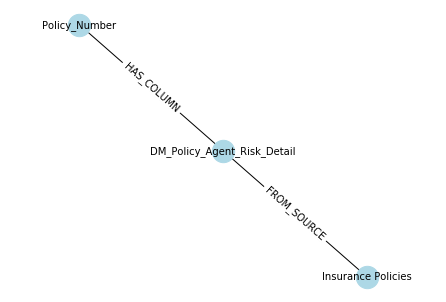

In [64]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()

for node in path.nodes:
    graph.add_node(node['name'], label=node["label"])  # Adjust the property key used for node labeling as per your data

for rel in path.relationships:
    graph.add_edge(rel.start_node['name'], rel.end_node['name'], label=rel.type)  # Adjust the property key used for relationship labeling as per your data

# Visualize the graph using Matplotlib
pos = nx.spring_layout(graph)
labels = nx.get_node_attributes(graph, "label")
edge_labels = nx.get_edge_attributes(graph, "label")

nx.draw(graph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

# Show the graph
plt.show()


## Finding Critical Data Assets by Degree Centrality

**Degree Centrality measures the number of connections or relationships a node has in a graph. In the context of data quality analysis, you can use Degree Centrality to identify metadata elements (nodes) that have a high number of relationships, indicating their significance or importance in the data ecosystem. Nodes with high Degree Centrality may represent critical tables, columns, or data entities that require careful attention and quality assessment.**

In [71]:
gds.run_cypher("""

CALL gds.graph.drop('myGraph',false) YIELD graphName;
""")

gds.run_cypher("""
CALL gds.graph.project(
  'myGraph',
  ['Table','Owner'],
  {
    IS_OWNED: {
      orientation: 'UNDIRECTED'
    }
  }
)
""")

gds.run_cypher("""
CALL gds.degree.stream('myGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score AS owners
ORDER BY owners DESC, name DESC
""")


,name,owners
0,dim_countries,3.0
1,Data Product,2.0
2,t_contract_master,1.0
3,customer_tier_sbx,1.0
4,Life Insurance,1.0
5,Data Science Engineer,1.0
6,Data Engineer,1.0
7,Data Platform Engineer,0.0
8,DM_Policy_Agent_Risk_Detail,0.0
